In [13]:

from pathlib import Path
import _pickle as pickle
import torch
from torch.utils.data import DataLoader
from collections import defaultdict, OrderedDict
import numpy as np

from train import load_hparams, load_model, load_checkpoint, make_aug_param_dictionary
from model import CnnEncoder
from data_utils import WindowedContourSet, ContourCollate, HummingPairSet, get_song_ids_of_selected_genre
from validation import get_contour_embeddings, cal_ndcg_single
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import random
import pandas as pd
import humming_data_utils as utils




def load_model(ckpt_dir):
    model_path = Path(ckpt_dir)
    # hparams = load_hparams(model_path / 'hparams.dat')
    with open(model_path / 'hparams.dat', 'rb') as f:
        hparams = pickle.load(f)
    model = CnnEncoder(hparams).cuda()
    model, _, _, _ = load_checkpoint(model_path/'checkpoint_best.pt', model, None, train_on_humming=True)

    return model


def prepare_dataset(data_dir='/home/svcapp/userdata/flo_data_backup/', selected_genres=[4, 12, 13, 17, 10, 7,15, 11, 9], num_workers=2, min_vocal_ratio=0.5):

    with open('flo_metadata_220k.dat', 'rb') as f:
        metadata = pickle.load(f)
    with open('humm_db_ids.dat', 'rb') as f:
        humm_ids = pickle.load(f)

    song_ids = get_song_ids_of_selected_genre(metadata, selected_genre=selected_genres)
    song_ids += humm_ids
#     song_ids = humm_ids
    # song_ids = [427396913, 5466183, 30894451, 421311716, 420497440]
    entireset = WindowedContourSet(data_dir, aug_weights=[], song_ids=song_ids, set_type='entire', pre_load=False, num_aug_samples=0, num_neg_samples=0, min_vocal_ratio=min_vocal_ratio)

    entire_loader = DataLoader(entireset, 512, shuffle=True,num_workers=num_workers,
        collate_fn=ContourCollate(0, 0, for_cnn=True), pin_memory=False, drop_last=False)

    # with open(hparams.humming_path, "rb") as f:
    with open('/home/svcapp/userdata/flo_melody/humming_db_contour_pairs.dat', 'rb') as f:
        contour_pairs = pickle.load(f)

    humm_test_set = HummingPairSet(contour_pairs, [], "test",[], num_aug_samples=0, num_neg_samples=0)
    humm_test_loader = DataLoader(humm_test_set, 1, shuffle=False,num_workers=num_workers,
        collate_fn=ContourCollate(0, 0, for_cnn=True), pin_memory=True, drop_last=False)

    selected_100, selected_900 = utils.load_meta_from_excel("/home/svcapp/userdata/humming_db/Spec.xlsx")

    meta_in_song_key = {x['track_id']: x for x in metadata}
    for song in selected_100.to_dict('records'):
        meta_in_song_key[song['track_id']] = song
    for song in selected_900.to_dict('records'):
        meta_in_song_key[song['track_id']] = song
    return entire_loader, humm_test_loader, meta_in_song_key


def evaluate(model, humm_test_loader, total_embs, total_song_ids, unique_ids, index_by_id):
    model.eval()
    num_correct_answer = 0
    total_success = []
    total_recommends = []
    total_test_ids = []
    total_rank = []
    with torch.no_grad():
    #     total_embs, total_song_ids = get_contour_embeddings(model, entire_loader)
        for j, batch in enumerate(humm_test_loader):
            contours, song_ids = batch
            anchor = model(contours.cuda())
            anchor_norm = anchor / anchor.norm(dim=1)[:, None]
            similarity = torch.mm(anchor_norm, total_embs.transpose(0,1))
            max_similarity_by_song = torch.max(similarity[:,index_by_id], dim=-1)[0]

            corresp_melody_ids = torch.where(total_song_ids==song_ids)[0]
            if len(corresp_melody_ids) ==0:
                max_similarity = -1
            else:
                max_similarity = torch.max(similarity[:, corresp_melody_ids])
            max_rank = torch.sum(max_similarity_by_song > max_similarity)
            recommends = torch.topk(max_similarity_by_song, k=30, dim=-1)[1]
            recommends = unique_ids[recommends]
            top10_success = [ int(int(song_ids[i]) in recommends[i,:10].tolist()) for i in range(recommends.shape[0])]
            total_success += top10_success
            total_recommends.append(recommends)
            total_test_ids.append(song_ids)
            total_rank.append(max_rank.item())
            
            num_correct_answer += sum(top10_success)
    print(num_correct_answer / len(humm_test_loader.dataset))
    total_recommends = torch.cat(total_recommends, dim=0).cpu().numpy()
    total_test_ids = torch.cat(total_test_ids, dim=0).cpu().numpy()
    return total_recommends, total_test_ids, total_rank

def get_index_by_id(total_song_ids):
    out = []
    unique_ids = list(set(total_song_ids.tolist()))
    for id in unique_ids:
        out.append(torch.where(total_song_ids==id)[0])
    max_len = max([len(x) for x in out])
    dummy = torch.zeros((len(unique_ids), max_len), dtype=torch.long)
    for i, ids in enumerate(out):
        dummy[i,:len(ids)] = ids
        dummy[i, len(ids):] = ids[-1]
    return torch.LongTensor(unique_ids), dummy

def get_similarity_by_id(similarity, unique_ids, index_by_ids):
    return

def convert_result_to_dict(ids, ranks, meta):
    out = defaultdict(list)
    for id, r in zip(ids, ranks):
        out[meta[id]['artist_name'] + ' - ' + meta[id]['track_name']].append(r)
    return dict(out)

def save_dict_result_to_csv(adict):
    return



In [ ]:
font_path = 'malgun.ttf'
font_name = fm.FontProperties(fname=font_path, size=50).get_name()
plt.rc('font', family=font_name)


In [ ]:
meta[427396913]

In [ ]:
flo_test_list = pd.read_csv('flo_test_list.csv')
flo_test_meta = {x['track id ']: x for x in flo_test_list.to_dict('records')}

In [ ]:
flo_test_meta

In [ ]:
entire_loader, humm_test_loader, meta = prepare_dataset(data_dir='/home/svcapp/t2meta/flo_new_music/music_100k/', min_vocal_ratio=0.3, selected_genres=[4])

In [ ]:
# worker_ids = [480785, 401032, 482492, 482457, 483461]
worker_ids = [482492]
model_dir = Path('/home/svcapp/t2meta/qbh_model')
for id in worker_ids:
    ckpt_dir = next(model_dir.glob(f"worker_{id}*"))
    model = load_model(ckpt_dir)
    total_embs, total_song_ids = get_contour_embeddings(model, entire_loader)
    unique_ids, index_by_id = get_index_by_id(total_song_ids)
    total_recommends, total_test_ids, total_rank = evaluate(model, humm_test_loader, total_embs, total_song_ids, unique_ids, index_by_id)
    out = convert_result_to_dict(total_test_ids, total_rank, meta)
    detail_out = convert_result_to_rec_title(total_test_ids, total_recommends, total_rank, meta)
    keys = sorted(out.keys())
    rank_array = np.asarray([out[x] for x in keys])
    fig = plt.figure(figsize=(20,20))
    ax = plt.gca()
    plt.imshow(1/(rank_array+1))
    plt.colorbar()
    ax.set_yticks(list(range(len(rank_array))))
    ax.set_yticklabels(keys)
    for label in ax.get_yticklabels() :
        label.set_fontproperties(font_prop)        
    plt.savefig(f'worker_{id}_eval_matrix.png')
    
    dataframe = pd.DataFrame(detail_out).transpose()
    dataframe.to_csv(f"worker_{id}_eval_table.csv")


# 결과 표에 곡명, 장르별로 정렬, Prof/Non-prof 구별 

In [ ]:
font_path = 'malgun.ttf'
font_prop = fm.FontProperties(fname=font_path, size=20)


out = convert_result_to_dict(total_test_ids, total_rank, meta)
detail_out = convert_result_to_rec_title(total_test_ids, total_recommends, total_rank, meta)

keys = sorted(out.keys())
rank_array = np.asarray([out[x] for x in keys])
fig = plt.figure(figsize=(20,20))
ax = plt.gca()
plt.imshow(1/(rank_array+1))
plt.colorbar()
ax.set_yticks(list(range(len(rank_array))))
ax.set_yticklabels(keys)
for label in ax.get_yticklabels() :
    label.set_fontproperties(font_prop)
plt.savefig(f'worker_{id}_eval_matrix.png')

dataframe = pd.DataFrame(detail_out).transpose()
dataframe.to_csv(f"worker_{id}_eval_table.csv")


In [ ]:
dataframe.insert(1, 'Class', [flo_test_meta[x]['해당 요건'] for x in dataframe[0].values])

In [ ]:
dataframe = dataframe.sort_values('Class')

In [ ]:
humm_meta = [x['meta'] for x in humm_test_loader.dataset.contours]
humm_meta[0]

In [ ]:
dataframe.insert(0, 'Class', [x['해당 요건'] for x in ])

In [ ]:
meta[total_recommends[0][-1]]

In [ ]:
rec_songs_in_name = []
def id_to_name(idx, meta):
    if 'artist_name' in meta[idx]:
        return f'{meta[idx]["artist_name"]} - {meta[idx]["track_name"]}'
    else:
        return f'{meta[idx]["artist_name_basket"][0]} - {meta[idx]["track_name"]}'
for rec in total_recommends:
    rec_songs_in_name.append([id_to_name(idx, meta) for idx in rec[:3]])

In [ ]:
def convert_result_to_rec_title(total_test_ids, total_recommends, total_rank, meta, humm_meta, k=3):
    out = {}
    for idx in total_test_ids:
        out[meta[idx]['artist_name'] + ' - ' + meta[idx]['track_name']] = [idx] + [ [] for i in range(5)]
    
    for idx, rec, r, humm in zip(total_test_ids, total_recommends, total_rank, humm_meta):
        target = out[meta[idx]['artist_name'] + ' - ' + meta[idx]['track_name']]
        string =  "\n".join([f'Rec rank: {r+1}'] + [id_to_name(idx, meta) for idx in rec[:k]]
                            + [f'Group: {humm["singer_group"]}', f'Singer ID: {humm["singer_id"]}', f'Gender: {humm["singer_gender"]}', f'Humm type: {humm["humming_type"]}'])
        if humm['singer_group'] == 'P':
            if target[1] == []:
                target[1] = string
            else:
                target[2] =  string
        else:
            if target[3] ==[]:
                target[3] =  string
            elif target[4] ==[]:
                target[4] =  string
            else:
                target[5] =  string

    return out

test_out = convert_result_to_rec_title(total_test_ids, total_recommends, total_rank, meta, humm_meta)

dataframe = pd.DataFrame(test_out).transpose()
dataframe.to_csv(f"worker_{id}_eval_table.csv")

In [ ]:
dataframe

In [ ]:
sorted_keys = dataframe.to_dict()[0].keys()

In [ ]:
sorted_out = [{x: out[x]} for x in sorted_keys]
sorted_out

In [ ]:
test[0]

In [ ]:
test[0].keys()

In [ ]:
test

In [24]:
dataframe = pd.read_csv('worker_483461_87k_eval_table_score0.648.csv')
dataframe30k = pd.read_csv('worker_483461_eval_table_score0.708.csv')

In [15]:
csv_dict = dataframe.to_dict('records')

In [12]:
np.mean( 1/ np.asarray([int(x[str(y)].split('\n')[0].split(': ')[-1]) for x in csv_dict for y in range(1,6)]))

0.48636234581457677

In [11]:
csv_dict[0][str(1)].split('\n')[0].split(': ')[-1]

['Rec rank', '1']

In [19]:
test=np.asarray([int(x[str(y)].split('\n')[0].split(': ')[-1]) for x in csv_dict for y in range(1,6)])

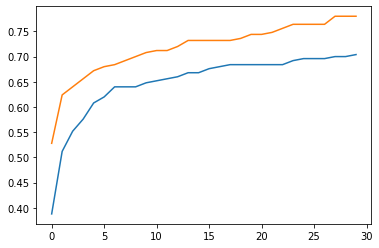

In [25]:
target = [dataframe, dataframe30k]
for df in target:
    csv_dict = df.to_dict('records')
    rank= np.asarray([int(x[str(y)].split('\n')[0].split(': ')[-1]) for x in csv_dict for y in range(1,6)])
    plt.plot([ np.mean(rank<=i+1) for i in range(30)])